In [20]:
# !pip install --user lightgbm==2.2.3 -i https://pypi.tuna.tsinghua.edu.cn/simple

In [21]:
# !pip install phik
# !pip install bayesian-optimization

In [22]:
# Importing modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical function packages
from scipy.stats import chi2_contingency
import phik
from bayes_opt import BayesianOptimization

# Machine Learning packages
import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.metrics import precision_score, recall_score, roc_curve, roc_auc_score, confusion_matrix, classification_report

# other packages
import os
import gc
import pickle
from datetime import datetime

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [23]:
# Data Folder
data_dir = './home-credit-default-risk'

# Excact Data Directory
app_train_dir = data_dir + '/application_train.csv'
app_test_dir = data_dir + '/application_test.csv'

bureau_dir = data_dir + '/bureau.csv'
bureau_balance_dir = data_dir + '/bureau_balance.csv'
pos_cash_balance_dir = data_dir + '/POS_CASH_balance.csv'
credit_card_balance_dir = data_dir + '/credit_card_balance.csv'
previous_application_dir = data_dir + '/previous_application.csv'
installments_payments_dir = data_dir + '/installments_payments.csv'

## Define Utility Wrapped Functions

#### Missing Values

In [24]:
# check missing values & with missing percentage
def count_missing_value(df, print_info=False):
    miss_value = df.isnull().sum()
    miss_percent = round(miss_value/df.shape[0], 4)
    miss_df = pd.concat([miss_value, miss_percent], axis=1)
    miss_df = miss_df.rename(columns={0:'miss_value', 1:'% miss_percentage'})
    miss_df = miss_df.loc[miss_df.miss_value!=0, :]
    
    miss_df = miss_df.sort_values(by='% miss_percentage',ascending=False)

    if print_info:
        print('There are {0} columns in total \nThere are {1} columns have miss values'.format(df.shape[1],miss_df.shape[0]))
    return miss_df

In [25]:
def plot_missing(miss_df, title_name, tight_layout = True, figsize = (20,8), grid = False, rotation = 90):

    # checking if there is any column with NaNs or not.
    if miss_df['miss_value'].sum() != 0:
        print(f"Number of columns having NaN values: {miss_df[miss_df['miss_value'] != 0].shape[0]} columns")

        # plotting the Bar-Plot for NaN percentages (only for columns with Non-Zero percentage of NaN values)
        plt.figure(figsize=figsize, tight_layout=tight_layout)
        temp_df = pd.DataFrame({'column': miss_df.index, 'miss_value': miss_df['miss_value'], 'percent': miss_df['% miss_percentage']})
        sns.barplot(x='column', y='percent', data=temp_df[temp_df['miss_value'] > 0])
        plt.xticks(rotation=rotation)
        plt.xlabel('Column Name')
        plt.ylabel('Percentage of NaN values')
        plt.title(f'Percentage of NaN values in {title_name}')
        if grid:
            plt.grid()
        plt.show()
    else:
        print(f"The dataframe {title_name} does not contain any NaN values.")

#### Pie chart of TARGET distribution (Defaulter / NonDefaulter)

In [26]:
def pie_target(df, title_name, my_dpi=96):
    target_distribution = df.TARGET.value_counts()
    labels = ['Non-Defaulter', 'Defaulter']

    plt.figure(figsize=(480/my_dpi,480/my_dpi),dpi=my_dpi)
    plt.pie(target_distribution,
            labels=labels,
    #         colors=["#d5695d", "#5d8ca8", "#65a479"], 
            autopct='%.2f%%',
            wedgeprops={'edgecolor':'r',
                        'linestyle':'--',
                        'alpha':0.5,}
           )
    plt.title(f'Distribution of {title_name}\'s Target Variable')
    plt.show()

#### Categorical Features EDA

phi-k matrix -- judge correlation coefficient among categorical features

In [27]:
def plot_phik_matrix(data, CATEGORICAL_FEATS, figsize = (20,20), mask_upper = True, tight_layout = True, linewidth = 0.1, fontsize = 10, cmap = 'Blues', show_target_top_corr = True, target_top_columns = 10):
    
    #first fetching only the categorical features
    phik_matrix = data[CATEGORICAL_FEATS].astype('object').phik_matrix()
    
    print('-'*100)
    
    if mask_upper:
        mask_array = np.ones(phik_matrix.shape)
        mask_array = np.triu(mask_array)
    else:
        mask_array = np.zeros(phik_matrix.shape)
        
    plt.figure(figsize = figsize, tight_layout = tight_layout)
    sns.heatmap(phik_matrix, annot = False, mask = mask_array, linewidth = linewidth, cmap = cmap)
    plt.xticks(rotation = 90, fontsize = fontsize)
    plt.yticks(rotation = 0, fontsize = fontsize)
    plt.title("Phi-K Correlation Heatmap for Categorical Features", fontsize=20)
    plt.show()
    print("-"*100)

    if show_target_top_corr:
        #Seeing the top columns with highest correlation with the target variable in application_train
        print("Categories with highest values of Phi-K Correlation value with Target Variable are:")
        phik_df = pd.DataFrame({'Column Name' : phik_matrix.TARGET.index[1:], 'Phik-Correlation' : phik_matrix.TARGET.values[1:]})
        phik_df = phik_df.sort_values(by = 'Phik-Correlation', ascending = False)
        display(phik_df.head(target_top_columns))
        print("-"*100) 

#### Numerical Features EDA

Pearson Correlation Heatmap

In [28]:
def plot_numerical_heatmap(data, NUMERICAL_FEATS, figsize=(17,17), linewidth=0.1, cmap='inferno'):
    corr = app_train_feats2target[NUMERICAL_FEATS].corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(corr, mask=mask, square=True, cmap=cmap, linewidth=linewidth)
        plt.title("Correlation Heatmap for Numerical Features", fontsize=20)
        plt.show()
        
    return corr

#### Feature Engineering part

In [29]:
# Categorical Feature Encoding
def feature_class_encoding(df, BI_CLASSES, MULTI_CLASSES):
    df[BI_CLASSES] = df[BI_CLASSES].apply(LabelEncoder().fit_transform)    # Label Encoder
    df = pd.get_dummies(df, columns=MULTI_CLASSES)    # One-hot Encoding
    print(df.shape)
    return df

Creating New Variables  
['DAYS_EMPLOYED_RATIO','EXTSOURCE_MEAN','EXTSOURCES_GM','ANNUITY_CREDIT_RATIO','ANNUITY_INCOME_RATIO','INCOME_CREDIT_RATIO','CREDIT_GOODS_RATIO','CREDIT_GOODS_DIFF']

In [30]:
def add_variable(df):
    # 1 DAYS_EMPLOYED_RATIO
    # We believe it is more reasonable to consider one's employment history relative to his/her age
    # So we add a variable to calculate the ratio.
    # The more time he/she spend in working in his/her whole life, he/she may be more responsible or capable,
    # and thus having more ability to repay
    df['DAYS_EMPLOYED_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']

    # The next two transform the credit score from external sources
    # 2 Simple average of EXT_SOURCE_1 to EXT_SOURCE_3
    df["EXTSOURCE_MEAN"] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)

    # 3 Geometric mean of EXT_SOURCE_1 to EXT_SOURCE_3, in case one client scores very high in one, but low in the other two
    df['EXTSOURCES_GM'] = pow(df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3'], 1/3)

    # The next three calculate ratios of annuity, income and credit amount. We postulate that higher income level relative to
    # loan amount should imply better ability to repay
    
    # 4 Ratio of loan annuity to the credit amount of the loan
    df['ANNUITY_CREDIT_RATIO'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

    # 5 Ratio of loan annuity to the income level of the loan
    df['ANNUITY_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']

    # 6 Ratio of income level of client to credit amount
    df['INCOME_CREDIT_RATIO'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']

    # The next two added variable consider the credit amount relative to the customer consumption
    # 7 Ratio of credit amount to value of goods purchased
    df["CREDIT_GOODS_RATIO"] = df["AMT_CREDIT"]/df["AMT_GOODS_PRICE"]
    # 8 Diff btw credit amount and value of goods purchased
    df["CREDIT_GOODS_DIFF"] = df["AMT_CREDIT"] - df["AMT_GOODS_PRICE"]

#### Model Training & Evaluation

In [31]:
def lgbm_evaluation(num_leaves, max_depth, min_split_gain, min_child_weight,
                    min_child_samples, subsample, colsample_bytree, reg_alpha, reg_lambda):
    '''
    Objective function for Bayesian Optimization of LightGBM's Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.
    
    Inputs: Hyperparamters to be tuned.
        num_leaves, max_depth, min_split_gain, min_child_weight,
        min_child_samples, subsample, colsample_bytree, reg_alpha, reg_lambda
        
    Returns:
        CV ROC-AUC Score
    '''
    
    params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
        'learning_rate' : 0.005,
        'n_estimators' : 10000,
        'n_jobs' : -1,
        'num_leaves' : int(round(num_leaves)),
        'max_depth' : int(round(max_depth)),
        'min_split_gain' : min_split_gain,
        'min_child_weight' : min_child_weight,
        'min_child_samples' : int(round(min_child_samples)),
        'subsample': subsample,
        'subsample_freq' : 1,
        'colsample_bytree' : colsample_bytree,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'verbosity' : -1,
        'seed' : 266
    }
    n_folds = 5    # 3
    stratified_cv = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = 33)
    
    cv_preds = np.zeros(X.shape[0])
    for train_indices, cv_indices in stratified_cv.split(X, y):

        x_tr = X.iloc[train_indices]
        y_tr = y.iloc[train_indices]
        x_cv = X.iloc[cv_indices]
        y_cv = y.iloc[cv_indices]

        lgbm_clf = lgb.LGBMClassifier(**params)
        lgbm_clf.fit(x_tr, y_tr, eval_set= [(x_cv, y_cv)],
                eval_metric='auc', verbose = False, early_stopping_rounds=200)

        cv_preds[cv_indices] = lgbm_clf.predict_proba(x_cv, num_iteration = lgbm_clf.best_iteration_)[:,1]

    return roc_auc_score(y, cv_preds)

In [32]:
class Boosting:
    '''
    Class for Boosting Ensembles and displaying results. Contains 6 methods:
    
        1. init method
        2. train method
        3. proba_to_class method
        4. tune_threshold method
        5. results method
        6. feat_importance_show
    '''

    def __init__(self, x_train, y_train, x_test, params, num_folds = 5, random_state = 33, verbose = True, save_model_to_pickle = False):
        '''
        Function to initialize the class members.
        
        Inputs:
            self
            x_train: DataFrame
                Training DataFrame
            y_train: DataFrame
                Training Class labels
            x_test: DataFrame
                Test DataFrame
            params: dict
                Parameters for the boosting ensemble
            num_folds: int, default = 3
                Number of folds for k-Fold Cross Validation
            random_state: int, default = 33
                Random State for Splitting the data for K-Fold Cross Validation
            verbose: bool, default = True
                Whether to keep verbosity or not
            save_model_to_pickle: bool, default = False
                Whether to save the model to pickle file or not
        
        Returns:
            None
        '''

        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.params = params
        self.num_folds = num_folds
        self.stratified_cv = StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = random_state)
        self.verbose = verbose
        self.save_model = save_model_to_pickle
        
    def train(self, booster, verbose = 400, early_stopping = 200, pickle_name = ''):
        '''
        Function to train the Classifier on given parameters. It fits the classifier for each fold, and for Cross Validation,
        uses Out-of-Fold Predictions. The test predictions are averaged predictions over each fold.
        
        Inputs:
            self
            booster: str
                Whether the booster is 'xgboost' or 'lightgbm'
            verbose: int, default = 400
                Number of boosting rounds for printint boosting results.
            early_stopping: int, default = 200
                Number of boosting rounds to look for early stopping
            pickle_name: str, default = ''
                The string to add to end of pickle file of model, if any
        
        Returns:
            None        
        '''
        
        self.train_preds_proba_mean = np.zeros(self.x_train.shape[0])
        #out-of-fold cv predictions
        self.cv_preds_proba = np.zeros(self.x_train.shape[0])
        self.test_preds_proba_mean = np.zeros(self.x_test.shape[0])
        #best threshold will be 
        self.best_threshold_train = 0
        self.feature_importance = pd.DataFrame()
        self.feature_importance['features'] = self.x_train.columns
        self.feature_importance['gain'] = np.zeros(self.x_train.shape[1])
        
        if self.verbose:
            print(f"Fitting the {booster} on Training Data with {self.num_folds} fold cross validation, and using Out-Of-Folds Predictions for Cross-Validation")
            start = datetime.now()
        
        for fold_number, (train_indices, cv_indices) in enumerate(self.stratified_cv.split(self.x_train, self.y_train), 1):
            if self.verbose:
                print(f"\n\tFold Number {fold_number}\n")
            
            x_tr = self.x_train.iloc[train_indices]
            y_tr = self.y_train.iloc[train_indices]
            x_cv = self.x_train.iloc[cv_indices]
            y_cv = self.y_train.iloc[cv_indices]
            
            if booster == 'xgboost':
                clf = XGBClassifier(**self.params)
            else:
                clf = LGBMClassifier(**self.params)
                
            clf.fit(x_tr, y_tr, eval_set = [(x_tr, y_tr), (x_cv, y_cv)], eval_metric = 'auc',
                     verbose = verbose, early_stopping_rounds = 200)
            
            if booster == 'xgboost':
                self.train_preds_proba_mean[train_indices] = clf.predict_proba(x_tr, ntree_limit = clf.get_booster().best_ntree_limit)[:, 1] / (self.num_folds - 1)
                self.cv_preds_proba[cv_indices] = clf.predict_proba(x_cv, ntree_limit = clf.get_booster().best_ntree_limit)[:,1]
                self.test_preds_proba_mean += clf.predict_proba(self.x_test, ntree_limit = clf.get_booster().best_ntree_limit)[:,1] / self.num_folds

                #feature importance
                gain_fold = clf.get_booster().get_score(importance_type = 'gain')
                feat_imp = pd.DataFrame()
                feat_imp['features'] = gain_fold.keys()
                feat_imp['gain'] = gain_fold.values()
            
            else:
                self.train_preds_proba_mean[train_indices] = clf.predict_proba(x_tr, num_iteration = clf.best_iteration_)[:,1] / (self.num_folds - 1)
                self.cv_preds_proba[cv_indices] = clf.predict_proba(x_cv, num_iteration = clf.best_iteration_)[:,1]
                self.test_preds_proba_mean += clf.predict_proba(self.x_test, num_iteration = clf.best_iteration_)[:,1] / self.num_folds

                #feature importance
                gain_fold = clf.booster_.feature_importance(importance_type='gain')
                feat_imp = pd.DataFrame()
                feat_imp['features'] = self.x_train.columns
                feat_imp['gain'] = gain_fold
            
            #tuning the threshold for optimal TPR and FPR from ROC Curve
            self.best_threshold_train += self.tune_threshold(self.y_train[train_indices], self.train_preds_proba_mean[train_indices]) / self.num_folds
            #concatenating the feature importance of each fold to original df
            self.feature_importance = pd.concat([self.feature_importance, feat_imp], axis = 0)

            if self.save_model:
                #saving the model into a pickle file
                with open(f'./pickle/clf_{booster}_fold_{fold_number}_model_{pickle_name}.pkl', 'wb') as f:
                    pickle.dump(clf, f)
          
        #mean feature importance averaged over all folds
        self.feature_importance = self.feature_importance.groupby('features', as_index = False).mean()
        #sorting the feature importance
        self.feature_importance = self.feature_importance.sort_values(by = 'gain', ascending = False)
        
        if self.verbose:
            print("Done.")
            print(f"Time elapsed = {datetime.now() - start}")
        gc.collect()
        
    def proba_to_class(self, proba, threshold):
        '''
        Function to convert a given probability to class label based on a threshold value.
        
        Inputs:
            self
            proba: numpy array
                Probabilities of class label = 1
            threshold: int
                Threshold probability to be considered as Positive or Negative Class Label
            
        Returns:
            Converted Class Label
        '''

        return np.where(proba >= threshold, 1, 0)
        
    def tune_threshold(self, true_labels, predicted_probas):
        '''
        Function to find the optimal threshold for maximizing the TPR and minimizing the FPR from ROC-AUC Curve.
        This is found out by using the J Statistic, which is J = TPR - FPR.
        Reference: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
        
        Inputs:
            self
            true_labels: numpy array or pandas series
                True Class Labels
            predicted_probas: numpy array
                Predicted Probability of Positive Class label
            
        Returns:
            Threshold probability.
        '''

        fpr, tpr, threshold = roc_curve(true_labels, predicted_probas)
        j_stat = tpr - fpr
        index_for_best_threshold = np.argmax(j_stat)
        
        return threshold[index_for_best_threshold]
           
    def results(self, roc_auc = True, precision_recall = True, confusion_matrix = True, cv_test_distribution = False):
        '''
        Function to display the final results of Train, CV and Test Dataset.
        
        Inputs:
            self
        
        Returns:
            None
        '''
        
        #getting the crisp class labels
        self.train_preds_class = self.proba_to_class(self.train_preds_proba_mean, self.best_threshold_train)
        self.cv_preds_class = self.proba_to_class(self.cv_preds_proba, self.best_threshold_train)
        self.test_preds_class = self.proba_to_class(self.test_preds_proba_mean, self.best_threshold_train)
        print("=" * 100)
        print("Train Results:")
        print(f"\nThe best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = {self.best_threshold_train}\n")
        if roc_auc:
            print(f"\tROC-AUC Score = {roc_auc_score(self.y_train, self.train_preds_proba_mean)}")
        if precision_recall:
            print(f"\tPrecision Score = {precision_score(self.y_train, self.train_preds_class)}")
            print(f"\tRecall Score = {recall_score(self.y_train, self.train_preds_class)}")
        print("CV Results:")
        if roc_auc:
            print(f"\tROC-AUC Score = {roc_auc_score(self.y_train, self.cv_preds_proba)}")
        if precision_recall:
            print(f"\tPrecision Score = {precision_score(self.y_train, self.cv_preds_class)}")
            print(f"\tRecall Score = {recall_score(self.y_train, self.cv_preds_class)}")

#         if confusion_matrix:
#             print('=' * 100)
#             print("Confusion, Precision and Recall Matrix on CV data:")
#             conf_mat = confusion_matrix(self.y_train, self.cv_preds_class)
#             conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
#             plt.figure(figsize = (7,6))
#             plt.title('Confusion Matrix Heatmap')
#             sns.heatmap(conf_mat, annot = True, fmt = 'g', linewidth = 0.5, annot_kws = {'size' : 15})
#             plt.show()
        
        if cv_test_distribution:
            print('=' * 100)
            print("Distribution of Original Class Labels and Predicted CV and Test Class Labels")
            plt.figure(figsize = (20,6))
            plt.subplot(1,3,1)
            plt.title('Class Distribution of Original Dataset')
            sns.countplot(self.y_train)
            plt.subplot(1,3,2)
            plt.title('Class Distribution of predicted Class Labels on CV')
            sns.countplot(self.cv_preds_class)
            plt.subplot(1,3,3)
            plt.title('Class Distribution of predicted Test Dataset')
            sns.countplot(self.test_preds_class)
            plt.show()
        print('=' * 100)
        
        gc.collect()
    
    def feat_importances_show(self, num_features, figsize = (10,15)):
        '''
        Function to display the top most important features.
        
        Inputs:
            self
            num_features: int
                Number of top features importances to display
            figsize: tuple, default = (10,15)
                Size of figure to be displayed
            
        Returns:
            None
        '''
        
        plt.figure(figsize = figsize) 
        sns.barplot(self.feature_importance['gain'].iloc[:num_features], self.feature_importance['features'].iloc[:num_features], orient = 'h')
        plt.title(f'Top {num_features} features as per classifier')
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature Names')
        plt.grid()
        plt.show()
        print('=' * 100)
        
        gc.collect()

## EDA for each dataset

### application_train.csv and application_test.csv

In [33]:
app_train = pd.read_csv(app_train_dir)
app_test = pd.read_csv(app_test_dir)

In [34]:
add_variable(app_train)
add_variable(app_test)

In [35]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_RATIO,EXTSOURCE_MEAN,EXTSOURCES_GM,ANNUITY_CREDIT_RATIO,ANNUITY_INCOME_RATIO,INCOME_CREDIT_RATIO,CREDIT_GOODS_RATIO,CREDIT_GOODS_DIFF
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,1.0,0.067329,0.161787,0.144914,0.060749,0.121978,0.498036,1.158397,55597.5
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.070862,0.466757,NaN,0.027598,0.132217,0.208736,1.145199,164002.5
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.011814,0.642739,NaN,0.050000,0.100000,0.500000,1.000000,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,0.159905,0.650442,NaN,0.094941,0.219900,0.431748,1.052803,15682.5
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.152418,0.322738,NaN,0.042623,0.179963,0.236842,1.000000,0.0


In [36]:
print(f"train size: {app_train.shape}")
print(f"test size: {app_test.shape}")

train size: (307511, 130)
test size: (48744, 129)


=======================   ID & Feature & Target split for app_train =======================

In [37]:
app_train_id = app_train[['SK_ID_CURR']]
app_train_feats = app_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
app_train_target = app_train[['TARGET']]

======================= ID & Feature split for app_test =======================

In [38]:
app_test_id = app_test[['SK_ID_CURR']]
app_test_feats = app_test.drop(['SK_ID_CURR'], axis=1)

#### Data type exploration
Features including: numerical & cateogircal features. Check each distribution for encoding preparation.
<!-- 
特征变量由number类和category类组成，首先查看一下训练集和测试集的特征类型分布，方便之后的编码操作。使用df.dtypes查看。 -->

In [39]:
app_train_feats.dtypes.value_counts()

float64    73
int64      39
object     16
dtype: int64

In [40]:
app_test_feats.dtypes.value_counts()

float64    73
int64      39
object     16
dtype: int64

There are 16 categorical features. 
<!-- 我们发现训练集和测试集中含有16列categorical 特征，查看一下分别是哪些：有些是涉及贷款的种类，比如cash或者revolving，有些是性别还有是否拥有车等等。我们现在有了一些认识，后面再进行处理。 -->

In [41]:
app_train_feats.select_dtypes('object').head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,reg oper account,block of flats,"Stone, brick",No
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School,reg oper account,block of flats,Block,No
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government,NaN,NaN,NaN,NaN
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,NaN,NaN,NaN,NaN
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion,NaN,NaN,NaN,NaN


#### Check missing values

In [42]:
# app_train
count_miss_train = count_missing_value(app_train, print_info=True)
count_miss_train

There are 130 columns in total 
There are 73 columns have miss values


,miss_value,% miss_percentage
COMMONAREA_AVG,214865,0.6987
COMMONAREA_MEDI,214865,0.6987
COMMONAREA_MODE,214865,0.6987
NONLIVINGAPARTMENTS_MEDI,213514,0.6943
NONLIVINGAPARTMENTS_AVG,213514,0.6943
...,...,...
DAYS_LAST_PHONE_CHANGE,1,0.0000
ANNUITY_CREDIT_RATIO,12,0.0000
ANNUITY_INCOME_RATIO,12,0.0000
CNT_FAM_MEMBERS,2,0.0000


Number of columns having NaN values: 73 columns


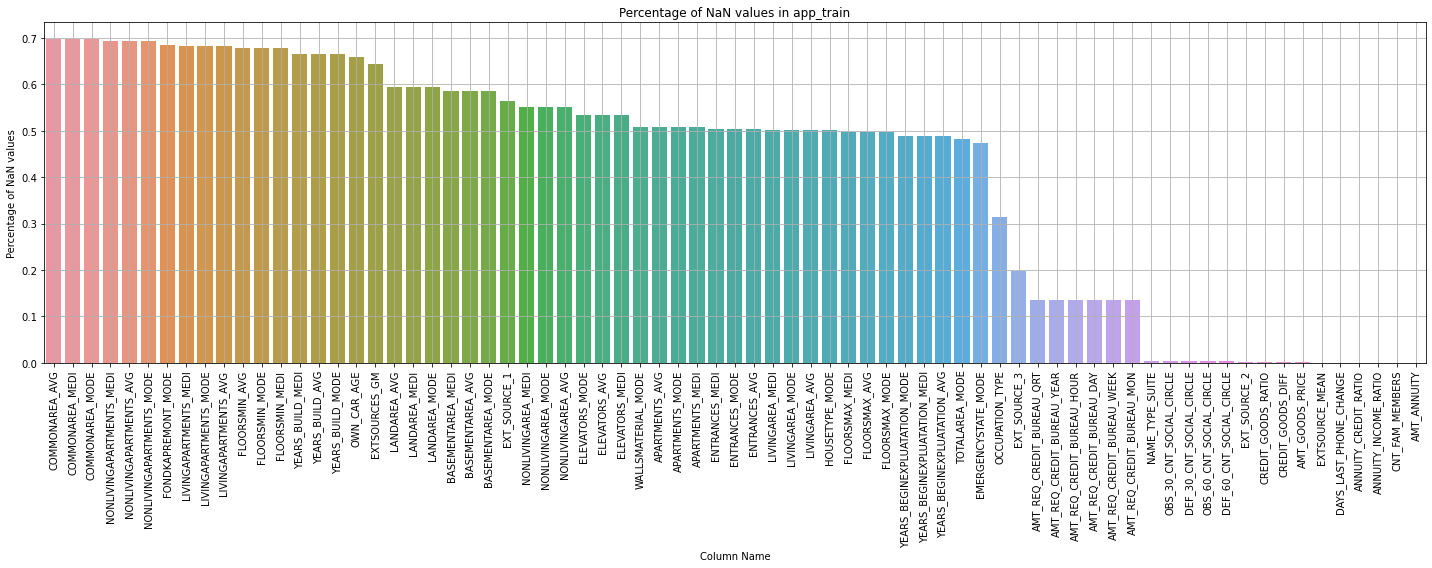

In [43]:
plot_missing(count_miss_train, 'app_train', grid = True)

In [44]:
# app_test
count_miss_test = count_missing_value(app_test, print_info=True)
count_miss_test

There are 129 columns in total 
There are 68 columns have miss values


,miss_value,% miss_percentage
COMMONAREA_MODE,33495,0.6872
COMMONAREA_AVG,33495,0.6872
COMMONAREA_MEDI,33495,0.6872
NONLIVINGAPARTMENTS_AVG,33347,0.6841
NONLIVINGAPARTMENTS_MODE,33347,0.6841
...,...,...
ANNUITY_CREDIT_RATIO,24,0.0005
AMT_ANNUITY,24,0.0005
ANNUITY_INCOME_RATIO,24,0.0005
EXT_SOURCE_2,8,0.0002


Number of columns having NaN values: 68 columns


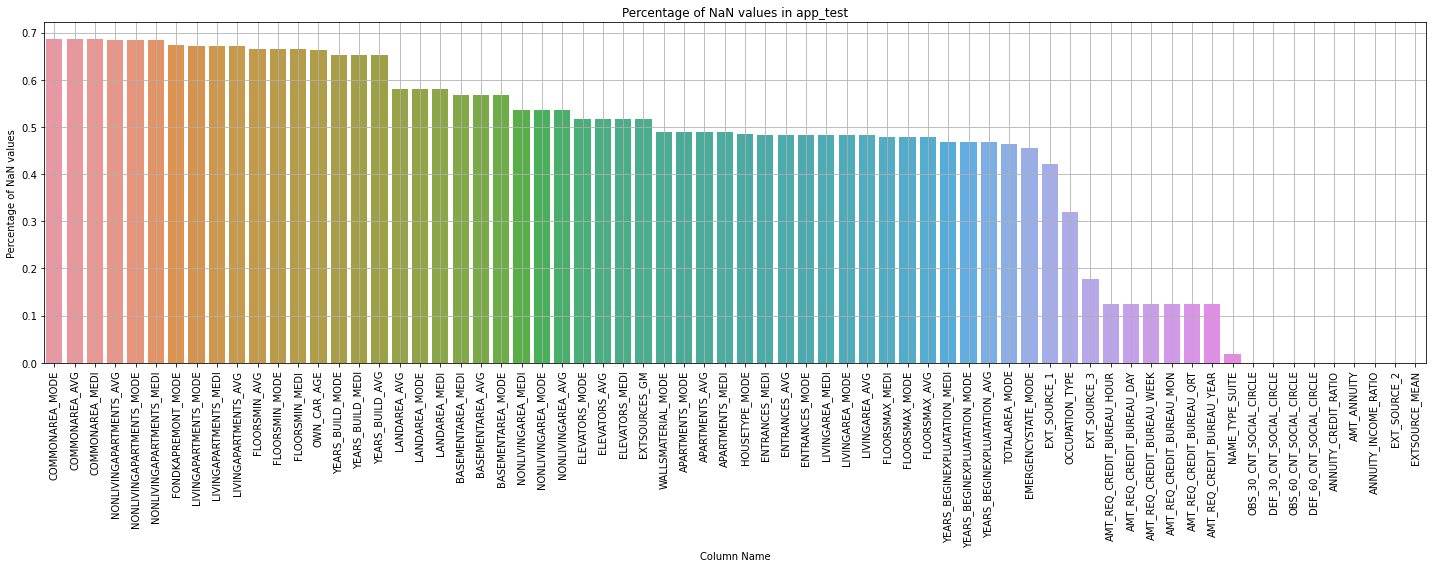

In [45]:
plot_missing(count_miss_test, 'app_test', grid = True)

#### Check distribution of 'Target' column

0: will repay on time
1: will have difficulty repaying loan


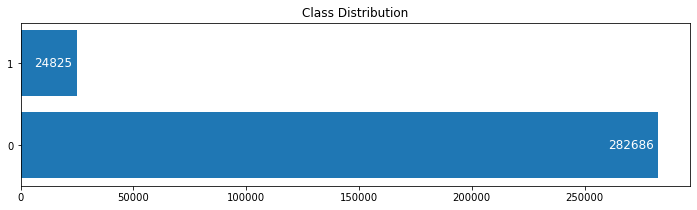

In [46]:
print("0: will repay on time")
print("1: will have difficulty repaying loan")

class_dist = app_train['TARGET'].value_counts()

plt.figure(figsize=(12,3))
plt.title('Class Distribution')
plt.barh(class_dist.index, class_dist.values)
plt.yticks([0, 1])

for i, value in enumerate(class_dist.values):
    plt.text(value-2000, i, str(value), fontsize=12, color='white',
             horizontalalignment='right', verticalalignment='center')

plt.show()

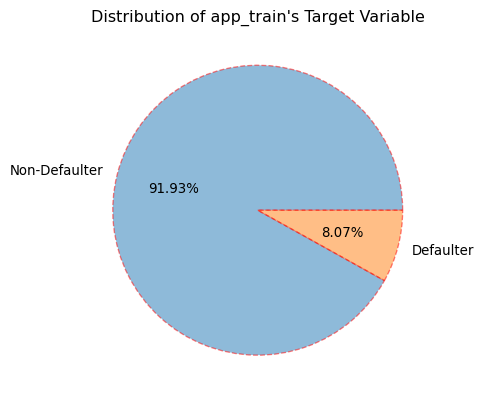

In [47]:
pie_target(app_train, 'app_train')

#### Categorical features
We can use **p-value of Chi-square test** to judge the importance of each categorical feature.

    H0: The variables are not correlated with each other. This is the H0 used in the Chi-square test.
    This means, if two variables are correlated, then the P-value will come very close to zero.

In [48]:
app_train_feats2target = pd.concat([app_train_feats, app_train_target], axis=1)

In [49]:
# CATEGORICAL_FEATS = list(app_train_feats.select_dtypes('object').columns)
# print(CATEGORICAL_FEATS, f'\n\nTotally {len(CATEGORICAL_FEATS)} categorical features.')

# We can directly find categorical features according to 'HomeCredit_columns_description.csv'
CATEGORICAL_FEATS = ['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE','FLAG_PHONE',\
                     'FLAG_EMAIL','REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY', 'REG_REGION_NOT_LIVE_REGION',\
                     'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', \
                     'LIVE_CITY_NOT_WORK_CITY'] + ['FLAG_DOCUMENT_' + str(i) for i in range(2,22)] + app_train_feats.dtypes[app_train_feats.dtypes == 'object'].index.tolist()
print(CATEGORICAL_FEATS, f'\n\nTotally {len(CATEGORICAL_FEATS)} categorical features.')

['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MOD

In [50]:
#########################################################
accepted_P_Value_dict = dict()

for each_FEAT in CATEGORICAL_FEATS:
    
    # Cross tabulation between each_FEAT and TARGET
    print(f'Feature {CATEGORICAL_FEATS.index(each_FEAT)+1}, {each_FEAT}:\n')
    CrosstabResult = pd.crosstab(index=app_train_feats2target[each_FEAT], columns=app_train_feats2target['TARGET'])
    print(CrosstabResult)

    # Performing Chi-sq test
    ChiSqResult = chi2_contingency(CrosstabResult)

    # P-Value is the Probability of H0 being True
    # If P-Value >= 0.05, then we Accept the assumption(H0)
    # If P-Value < 0.05, then we reject the assumption H0, which indicates significant variables.
    p_value = ChiSqResult[1]
    print(f'The P-Value of the ChiSq Test is: {p_value}\n\n')
    
    if p_value < 0.05:
        accepted_P_Value_dict[each_FEAT] = p_value

Feature 1, FLAG_MOBIL:

TARGET           0      1
FLAG_MOBIL               
0                1      0
1           282685  24825
The P-Value of the ChiSq Test is: 0.12378615154489829


Feature 2, FLAG_EMP_PHONE:

TARGET               0      1
FLAG_EMP_PHONE               
0                52395   2991
1               230291  21834
The P-Value of the ChiSq Test is: 2.5306059279614537e-143


Feature 3, FLAG_WORK_PHONE:

TARGET                0      1
FLAG_WORK_PHONE               
0                227282  18921
1                 55404   5904
The P-Value of the ChiSq Test is: 2.6758000919452704e-56


Feature 4, FLAG_CONT_MOBILE:

TARGET                 0      1
FLAG_CONT_MOBILE               
0                    529     45
1                 282157  24780
The P-Value of the ChiSq Test is: 0.8976989816319643


Feature 5, FLAG_PHONE:

TARGET           0      1
FLAG_PHONE               
0           202336  18744
1            80350   6081
The P-Value of the ChiSq Test is: 9.489418049556951e-40

TARGET                              0      1
NAME_EDUCATION_TYPE                         
Academic degree                   161      3
Higher education                70854   4009
Incomplete higher                9405    872
Lower secondary                  3399    417
Secondary / secondary special  198867  19524
The P-Value of the ChiSq Test is: 2.4476812052198174e-219


Feature 42, NAME_FAMILY_STATUS:

TARGET                     0      1
NAME_FAMILY_STATUS                 
Civil marriage         26814   2961
Married               181582  14850
Separated              18150   1620
Single / not married   40987   4457
Unknown                    2      0
Widow                  15151    937
The P-Value of the ChiSq Test is: 7.744841561414037e-107


Feature 43, NAME_HOUSING_TYPE:

TARGET                    0      1
NAME_HOUSING_TYPE                 
Co-op apartment        1033     89
House / apartment    251596  21272
Municipal apartment   10228    955
Office apartment       2445    172
Ren

In [51]:
P_values_sorted = dict(sorted(accepted_P_Value_dict.items(), key=lambda x:x[1]))
P_values_sorted

{'ORGANIZATION_TYPE': 5.224541090300172e-299,
 'OCCUPATION_TYPE': 3.7844998567642684e-288,
 'NAME_INCOME_TYPE': 1.9281456056861122e-266,
 'REGION_RATING_CLIENT_W_CITY': 5.05571529094165e-249,
 'REGION_RATING_CLIENT': 1.8283164955910817e-232,
 'NAME_EDUCATION_TYPE': 2.4476812052198174e-219,
 'CODE_GENDER': 1.1290217848908289e-200,
 'REG_CITY_NOT_WORK_CITY': 7.98127695863221e-176,
 'FLAG_EMP_PHONE': 2.5306059279614537e-143,
 'REG_CITY_NOT_LIVE_CITY': 1.0752352295806783e-133,
 'FLAG_DOCUMENT_3': 1.8557477135709125e-133,
 'NAME_FAMILY_STATUS': 7.744841561414037e-107,
 'NAME_HOUSING_TYPE': 1.0990890032617707e-88,
 'LIVE_CITY_NOT_WORK_CITY': 1.2629385266970663e-72,
 'NAME_CONTRACT_TYPE': 1.0235150721172847e-65,
 'FLAG_DOCUMENT_6': 1.425605347566481e-56,
 'FLAG_WORK_PHONE': 2.6758000919452704e-56,
 'FLAG_PHONE': 9.489418049556951e-40,
 'FLAG_OWN_CAR': 9.330994431109667e-34,
 'WALLSMATERIAL_MODE': 1.4531802848120748e-27,
 'FLAG_DOCUMENT_16': 1.4804321259373877e-10,
 'FLAG_DOCUMENT_13': 1.92162

In [52]:
print(list(P_values_sorted.keys()))

['ORGANIZATION_TYPE', 'OCCUPATION_TYPE', 'NAME_INCOME_TYPE', 'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT', 'NAME_EDUCATION_TYPE', 'CODE_GENDER', 'REG_CITY_NOT_WORK_CITY', 'FLAG_EMP_PHONE', 'REG_CITY_NOT_LIVE_CITY', 'FLAG_DOCUMENT_3', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'FLAG_DOCUMENT_6', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_OWN_CAR', 'WALLSMATERIAL_MODE', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'HOUSETYPE_MODE', 'EMERGENCYSTATE_MODE', 'FLAG_DOCUMENT_8', 'NAME_TYPE_SUITE', 'FLAG_DOCUMENT_18', 'REG_REGION_NOT_WORK_REGION', 'FLAG_DOCUMENT_15', 'FLAG_OWN_REALTY', 'FONDKAPREMONT_MODE', 'REG_REGION_NOT_LIVE_REGION', 'FLAG_DOCUMENT_2', 'WEEKDAY_APPR_PROCESS_START', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_11']


Combining phi-k correlation for judging the most significant categorical variables.

----------------------------------------------------------------------------------------------------


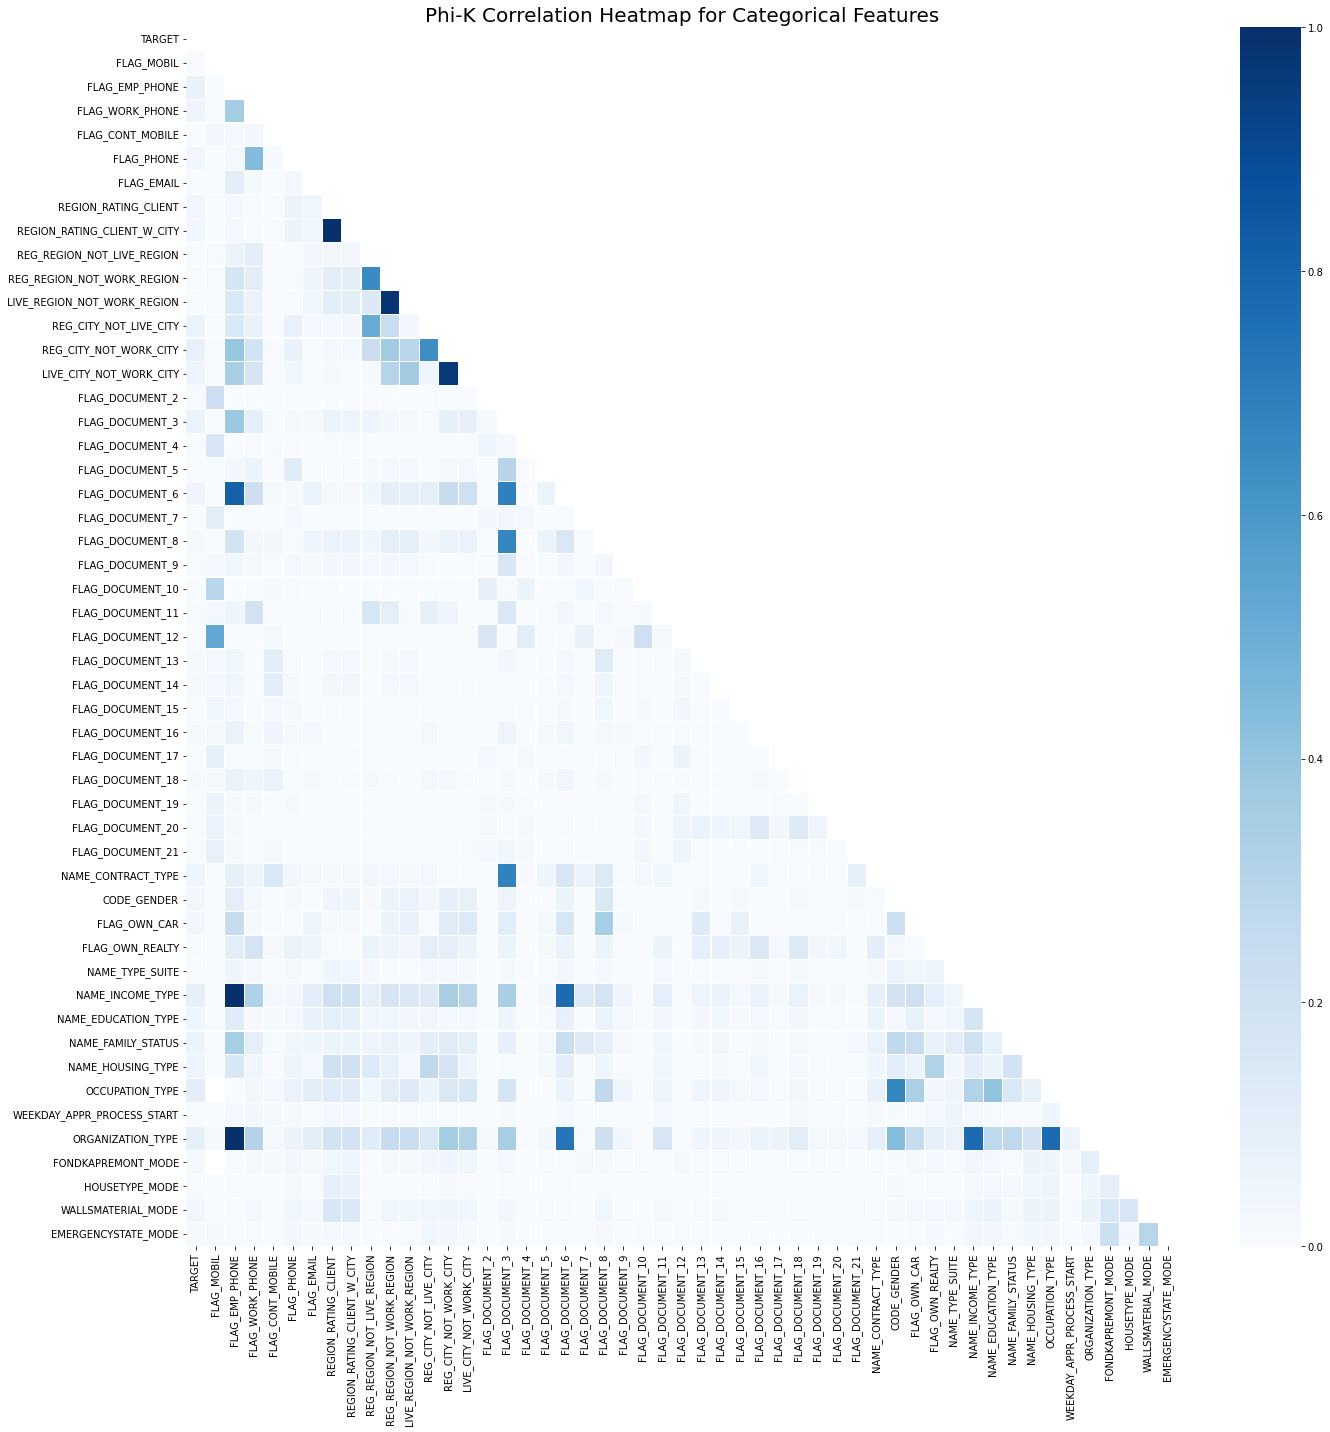

----------------------------------------------------------------------------------------------------
Categories with highest values of Phi-K Correlation value with Target Variable are:


,Column Name,Phik-Correlation
43,OCCUPATION_TYPE,0.102846
45,ORGANIZATION_TYPE,0.089164
39,NAME_INCOME_TYPE,0.084831
12,REG_CITY_NOT_WORK_CITY,0.079946
1,FLAG_EMP_PHONE,0.072087
11,REG_CITY_NOT_LIVE_CITY,0.069588
15,FLAG_DOCUMENT_3,0.069525
41,NAME_FAMILY_STATUS,0.056043
42,NAME_HOUSING_TYPE,0.051107
13,LIVE_CITY_NOT_WORK_CITY,0.050956


----------------------------------------------------------------------------------------------------


In [53]:
plot_phik_matrix(app_train, ['TARGET']+CATEGORICAL_FEATS)

High-correlated Features: (these features we can just select one of them, due to the high colinearity)
1. REGION_RATING_CLIENT_W_CITY & REGION_RATING_CLIENT (keep **REGION_RATING_CLIENT_W_CITY**, due to lower p-value)
2. LIVE_REGION_NOT_WORK_REGION & REG_REGION_NOT_WORK_REGION (not necessay to keep both)
3. LIVE_CITY_NOT_WORK_CITY & REG_CITY_NOT_WORK_CITY (keep **REG_CITY_NOT_WORK_CITY**, due to lower p-value & higher Phik-correlation)
4. NAME_INCOME_TYPE & FLAG_EMP_PHONE (keep **NAME_INCOME_TYPE**)
5. ORGANIZATION_TYPE & FLAG_EMP_PHONE (keep **ORGANIZATION_TYPE**)

Finally, we can select:

**['ORGANIZATION_TYPE', 'OCCUPATION_TYPE', 'NAME_INCOME_TYPE', 'REGION_RATING_CLIENT_W_CITY', 'NAME_EDUCATION_TYPE', 'CODE_GENDER', 'REG_CITY_NOT_WORK_CITY', 'REG_CITY_NOT_LIVE_CITY', 'FLAG_DOCUMENT_3', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'LIVE_CITY_NOT_WORK_CITY']**
    
    12 categorical columns into our selected features.

#### Numerical features correlation heatmap

In [54]:
# "pure-numerical type"
NUMERICAL_FEATS = list(set(app_train_feats.columns)-set(CATEGORICAL_FEATS))
print(NUMERICAL_FEATS, f'\n\nTotally {len(NUMERICAL_FEATS)} float-type features.')

['COMMONAREA_MEDI', 'APARTMENTS_AVG', 'CNT_CHILDREN', 'OWN_CAR_AGE', 'NONLIVINGAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'YEARS_BUILD_MEDI', 'ELEVATORS_MODE', 'EXT_SOURCE_1', 'AMT_REQ_CREDIT_BUREAU_QRT', 'BASEMENTAREA_MEDI', 'APARTMENTS_MODE', 'EXT_SOURCE_3', 'NONLIVINGAPARTMENTS_MODE', 'YEARS_BUILD_MODE', 'FLOORSMAX_MODE', 'LIVINGAREA_AVG', 'CNT_FAM_MEMBERS', 'LIVINGAPARTMENTS_AVG', 'APARTMENTS_MEDI', 'HOUR_APPR_PROCESS_START', 'LANDAREA_AVG', 'FLOORSMIN_AVG', 'BASEMENTAREA_MODE', 'EXTSOURCES_GM', 'AMT_REQ_CREDIT_BUREAU_DAY', 'YEARS_BEGINEXPLUATATION_MEDI', 'COMMONAREA_AVG', 'DAYS_LAST_PHONE_CHANGE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'EXTSOURCE_MEAN', 'FLOORSMIN_MEDI', 'FLOORSMAX_AVG', 'EXT_SOURCE_2', 'DAYS_EMPLOYED_RATIO', 'ELEVATORS_AVG', 'AMT_ANNUITY', 'ANNUITY_INCOME_RATIO', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DAYS_BIRTH', 'NONLIVINGAREA_AVG', 'CREDIT_GOODS_RATIO', 'DAYS_EMPLOYED', 'ENTRANCES_MODE', 'DAYS_REGISTRATION', 'AMT_REQ_CREDIT_BUREAU_MON', 'LANDAREA_MEDI', 'FL

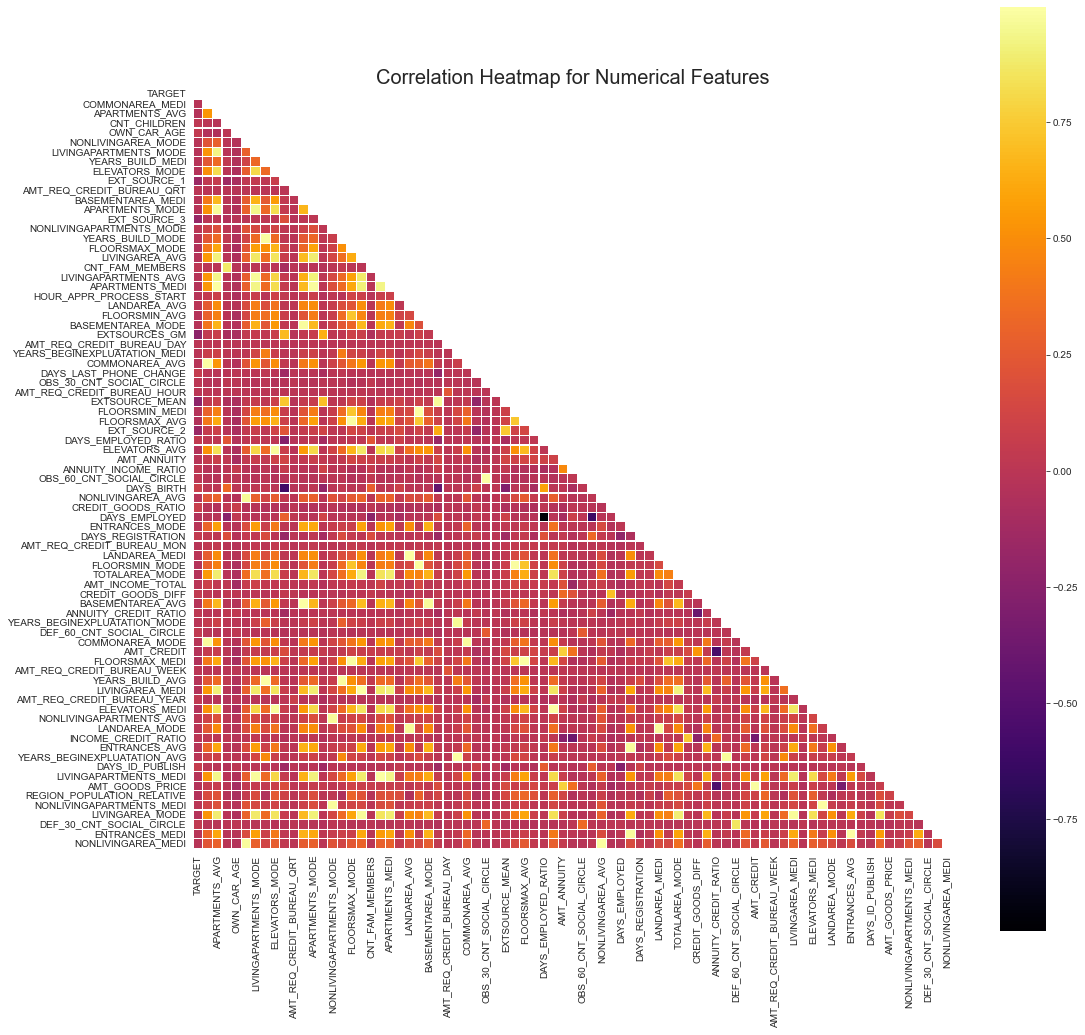

,TARGET,COMMONAREA_MEDI,APARTMENTS_AVG,CNT_CHILDREN,OWN_CAR_AGE,NONLIVINGAREA_MODE,LIVINGAPARTMENTS_MODE,YEARS_BUILD_MEDI,ELEVATORS_MODE,EXT_SOURCE_1,...,YEARS_BEGINEXPLUATATION_AVG,DAYS_ID_PUBLISH,LIVINGAPARTMENTS_MEDI,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,NONLIVINGAPARTMENTS_MEDI,LIVINGAREA_MODE,DEF_30_CNT_SOCIAL_CIRCLE,ENTRANCES_MEDI,NONLIVINGAREA_MEDI
TARGET,1.000000,-0.018573,-0.029498,0.019187,0.037612,-0.012711,-0.023393,-0.022326,-0.032131,-0.155317,...,-0.009728,0.051457,-0.024621,-0.039645,-0.037227,-0.002757,-0.030685,0.032248,-0.019025,-0.013337
COMMONAREA_MEDI,-0.018573,1.000000,0.539610,0.000609,-0.035066,0.218972,0.529557,0.232778,0.507060,0.032147,...,0.091667,0.000372,0.536985,0.049519,0.160275,0.105944,0.527076,-0.012343,0.326372,0.228645
APARTMENTS_AVG,-0.029498,0.539610,1.000000,-0.013222,-0.051177,0.284942,0.930554,0.339670,0.822553,0.054034,...,0.100098,-0.007322,0.941907,0.064918,0.205942,0.192635,0.893463,-0.013608,0.607629,0.297454
CNT_CHILDREN,0.019187,0.000609,-0.013222,1.000000,0.008494,0.000231,-0.007955,0.030124,-0.006397,-0.138470,...,0.006902,-0.028019,-0.007962,-0.001827,-0.025573,0.004133,-0.009517,-0.001262,-0.008325,0.000061
OWN_CAR_AGE,0.037612,-0.035066,-0.051177,0.008494,1.000000,-0.027811,-0.044226,-0.048787,-0.061365,-0.083411,...,0.000418,0.008633,-0.050121,-0.103733,-0.081429,-0.024251,-0.055302,0.008868,-0.017280,-0.030684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NONLIVINGAPARTMENTS_MEDI,-0.002757,0.105944,0.192635,0.004133,-0.024251,0.210271,0.142787,0.069126,0.114100,0.015263,...,0.034079,-0.003288,0.157284,0.014381,0.021873,1.000000,0.128294,0.004370,0.062346,0.218105
LIVINGAREA_MODE,-0.030685,0.527076,0.893463,-0.009517,-0.055302,0.295725,0.878471,0.337614,0.855978,0.062046,...,0.089123,-0.012096,0.857379,0.069324,0.180932,0.128294,1.000000,-0.014851,0.622235,0.290368
DEF_30_CNT_SOCIAL_CIRCLE,0.032248,-0.012343,-0.013608,-0.001262,0.008868,-0.009908,-0.014732,-0.010672,-0.020207,-0.028751,...,-0.005107,0.002738,-0.014474,-0.022244,0.006329,0.004370,-0.014851,1.000000,-0.002537,-0.011062
ENTRANCES_MEDI,-0.019025,0.326372,0.607629,-0.008325,-0.017280,0.170664,0.574676,0.087491,0.404202,0.021488,...,0.041334,-0.015647,0.567221,0.017585,0.033628,0.062346,0.622235,-0.002537,1.000000,0.165916


In [55]:
corr_mat = plot_numerical_heatmap(app_train, ['TARGET']+NUMERICAL_FEATS)
corr_mat

In [56]:
abs_correlation = corr_mat.abs()['TARGET'].sort_values(ascending=False)
print(f'Top-10 related：\n{abs_correlation.head(10)}\n')
print('********************************************')

correlation = corr_mat['TARGET'].sort_values(ascending=False)
print(f'Top-10 positive related：\n{correlation.head(10)}\n')
print(f'Top-10 negative related：\n{correlation.tail(10)}')

Top-10 related：
TARGET                    1.000000
EXTSOURCES_GM             0.232671
EXTSOURCE_MEAN            0.222052
EXT_SOURCE_3              0.178919
EXT_SOURCE_2              0.160472
EXT_SOURCE_1              0.155317
DAYS_BIRTH                0.078239
CREDIT_GOODS_RATIO        0.069427
DAYS_LAST_PHONE_CHANGE    0.055218
DAYS_ID_PUBLISH           0.051457
Name: TARGET, dtype: float64

********************************************
Top-10 positive related：
TARGET                      1.000000
DAYS_BIRTH                  0.078239
CREDIT_GOODS_RATIO          0.069427
DAYS_LAST_PHONE_CHANGE      0.055218
DAYS_ID_PUBLISH             0.051457
DAYS_EMPLOYED_RATIO         0.042206
DAYS_REGISTRATION           0.041975
OWN_CAR_AGE                 0.037612
CREDIT_GOODS_DIFF           0.034254
DEF_30_CNT_SOCIAL_CIRCLE    0.032248
Name: TARGET, dtype: float64

Top-10 negative related：
AMT_GOODS_PRICE   -0.039645
FLOORSMAX_MODE    -0.043226
FLOORSMAX_MEDI    -0.043768
FLOORSMAX_AVG     -0.0440

In [57]:
abs_correlation.index[:10]

Index(['TARGET', 'EXTSOURCES_GM', 'EXTSOURCE_MEAN', 'EXT_SOURCE_3',
       'EXT_SOURCE_2', 'EXT_SOURCE_1', 'DAYS_BIRTH', 'CREDIT_GOODS_RATIO',
       'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH'],
      dtype='object')

if we choose 0.05 as our correlation threshold, we can select:

**['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'DAYS_BIRTH','DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH']**

    6 numerical columns into our selected features.

**Summarization:**

    Totally select 18 features for app_train | test data. (120 features reduced to 18 features!!!)
    
**['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'DAYS_BIRTH','DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH',\
    'ORGANIZATION_TYPE', 'OCCUPATION_TYPE', 'NAME_INCOME_TYPE', 'REGION_RATING_CLIENT_W_CITY', 'NAME_EDUCATION_TYPE', 'CODE_GENDER', 'REG_CITY_NOT_WORK_CITY', 'REG_CITY_NOT_LIVE_CITY', 'FLAG_DOCUMENT_3', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'LIVE_CITY_NOT_WORK_CITY']**

### Explore the overlap of other csv

In [94]:
bureau = pd.read_csv(bureau_dir)
bureau_balance = pd.read_csv(bureau_balance_dir)
pos_cash_balance = pd.read_csv(pos_cash_balance_dir)
credit_card_balance = pd.read_csv(credit_card_balance_dir)
previous_application = pd.read_csv(previous_application_dir)
installments_payments = pd.read_csv(installments_payments_dir)
# !pip install matplotlib_venn


from matplotlib_venn import venn2 

def check_SK_ID_CURR_overlap(df,name): 
    '''
    Check the number of SK_ID_CURR overlap the supporting table has with the training and testing set
    '''
    unique_loan_df = len(df.SK_ID_CURR.unique())
    print(f'Number of unique SK_ID_CURR in table are: {unique_loan_df}')
    print('-'*50)
    unique_loan_app_train = len(app_train.SK_ID_CURR.unique())
    unique_loan_overlap1 = len(set(app_train.SK_ID_CURR.unique()).intersection(set(df.SK_ID_CURR.unique())))
    print(f'{len(set(app_train.SK_ID_CURR.unique()).intersection(set(df.SK_ID_CURR.unique())))} application_train.csv')
    unique_loan_app_test = len(app_test.SK_ID_CURR.unique())
    unique_loan_overlap2 = len(set(app_test.SK_ID_CURR.unique()).intersection(set(df.SK_ID_CURR.unique())))
    print(f'{len(set(app_test.SK_ID_CURR.unique()).intersection(set(df.SK_ID_CURR.unique())))} SK_ID_CURR overlap with application_test.csv')
    print('-'*50)
    
    plt.style.use('seaborn-pastel')

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('SK_ID_CURR Overlap')

    v = venn2(subsets=(unique_loan_app_train-unique_loan_overlap1,unique_loan_df-unique_loan_overlap1,unique_loan_overlap1),ax=ax1)
    v.get_label_by_id('100').set_text('Train')
    v.get_label_by_id('010').set_text(name)
    ax1.set_title('Training Set')

    v2 = venn2(subsets=(unique_loan_app_test-unique_loan_overlap2,unique_loan_df-unique_loan_overlap2,unique_loan_overlap2),ax=ax2)
    v2.get_label_by_id('100').set_text('Test')
    v2.get_label_by_id('010').set_text(name)

    ax2.set_title('Testing Set')
    fig.show()

### bureau.csv

Number of unique SK_ID_CURR in table are: 305811
--------------------------------------------------
263491 application_train.csv
42320 SK_ID_CURR overlap with application_test.csv
--------------------------------------------------


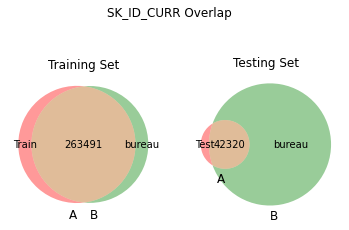

In [95]:
check_SK_ID_CURR_overlap(bureau,'bureau')

### bureau_balance.csv

In [59]:
#bureau_balance

### POS_CASH_balance.csv

In [60]:
#pos_cash_balance

### credit_card_balance.csv

Number of unique SK_ID_CURR in table are: 103558
--------------------------------------------------
86905 application_train.csv
16653 SK_ID_CURR overlap with application_test.csv
--------------------------------------------------


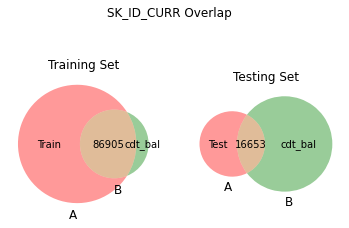

In [96]:
#credit_card_balance
check_SK_ID_CURR_overlap(credit_card_balance,'cdt_bal')

### previous_application.csv

Number of unique SK_ID_CURR in table are: 338857
--------------------------------------------------
291057 application_train.csv
47800 SK_ID_CURR overlap with application_test.csv
--------------------------------------------------


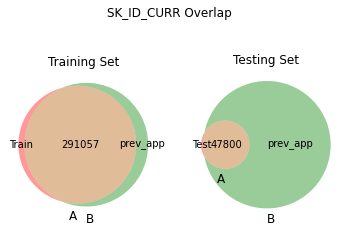

In [97]:
#previous_application
check_SK_ID_CURR_overlap(previous_application,'prev_app')

### installments_payments.csv

Number of unique SK_ID_CURR in table are: 92334
--------------------------------------------------
79173 application_train.csv
13161 SK_ID_CURR overlap with application_test.csv
--------------------------------------------------


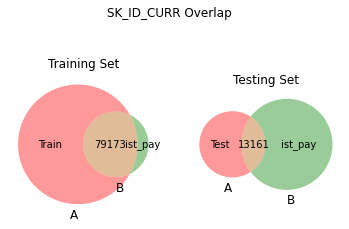

In [98]:
#installments_payments
check_SK_ID_CURR_overlap(installments_payments,'ist_pay')

## Data Preprocessing & Feature Engineering

### 1. app_{train | test} dataset

#### Missing Value processing

In [64]:
CATE_FEATS = ['ORGANIZATION_TYPE', 'OCCUPATION_TYPE', 'NAME_INCOME_TYPE', 'REGION_RATING_CLIENT_W_CITY', 'NAME_EDUCATION_TYPE', 'CODE_GENDER', 'REG_CITY_NOT_WORK_CITY', 'REG_CITY_NOT_LIVE_CITY', 'FLAG_DOCUMENT_3', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'LIVE_CITY_NOT_WORK_CITY']
NUM_FEATS = ['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'DAYS_BIRTH', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH','DAYS_EMPLOYED_RATIO','EXTSOURCE_MEAN','EXTSOURCES_GM','ANNUITY_CREDIT_RATIO','ANNUITY_INCOME_RATIO','INCOME_CREDIT_RATIO','CREDIT_GOODS_RATIO','CREDIT_GOODS_DIFF']

app_features = CATE_FEATS + NUM_FEATS

app_train_cate_df = app_train[CATE_FEATS].astype('object')   # convert mixed-type to unique "object" type
app_train_num_df = app_train[NUM_FEATS]

app_test_cate_df = app_test[CATE_FEATS].astype('object')
app_test_num_df = app_test[NUM_FEATS]

In [65]:
app_train_feats_reduced = pd.concat([app_train_cate_df, app_train_num_df], axis=1)    # train features!!!
app_train_df = pd.concat([app_train_id, app_train_target, app_train_feats_reduced], axis=1)

app_test_feats_reduced = pd.concat([app_test_cate_df, app_test_num_df], axis=1)    # test features!!!
app_test_df = pd.concat([app_test_id, app_test_feats_reduced], axis=1)

app_train_df.head()

,SK_ID_CURR,TARGET,ORGANIZATION_TYPE,OCCUPATION_TYPE,NAME_INCOME_TYPE,REGION_RATING_CLIENT_W_CITY,NAME_EDUCATION_TYPE,CODE_GENDER,REG_CITY_NOT_WORK_CITY,REG_CITY_NOT_LIVE_CITY,...,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,DAYS_EMPLOYED_RATIO,EXTSOURCE_MEAN,EXTSOURCES_GM,ANNUITY_CREDIT_RATIO,ANNUITY_INCOME_RATIO,INCOME_CREDIT_RATIO,CREDIT_GOODS_RATIO,CREDIT_GOODS_DIFF
0,100002,1,Business Entity Type 3,Laborers,Working,2,Secondary / secondary special,M,0,0,...,-1134.0,-2120,0.067329,0.161787,0.144914,0.060749,0.121978,0.498036,1.158397,55597.5
1,100003,0,School,Core staff,State servant,1,Higher education,F,0,0,...,-828.0,-291,0.070862,0.466757,NaN,0.027598,0.132217,0.208736,1.145199,164002.5
2,100004,0,Government,Laborers,Working,2,Secondary / secondary special,M,0,0,...,-815.0,-2531,0.011814,0.642739,NaN,0.050000,0.100000,0.500000,1.000000,0.0
3,100006,0,Business Entity Type 3,Laborers,Working,2,Secondary / secondary special,F,0,0,...,-617.0,-2437,0.159905,0.650442,NaN,0.094941,0.219900,0.431748,1.052803,15682.5
4,100007,0,Religion,Core staff,Working,2,Secondary / secondary special,M,1,0,...,-1106.0,-3458,0.152418,0.322738,NaN,0.042623,0.179963,0.236842,1.000000,0.0


In [66]:
# app_train_df
count_miss_train1 = count_missing_value(app_train_df, print_info=True)
count_miss_train1

There are 28 columns in total 
There are 11 columns have miss values


,miss_value,% miss_percentage
EXTSOURCES_GM,197922,0.6436
EXT_SOURCE_1,173378,0.5638
OCCUPATION_TYPE,96391,0.3135
EXT_SOURCE_3,60965,0.1983
EXT_SOURCE_2,660,0.0021
CREDIT_GOODS_RATIO,278,0.0009
CREDIT_GOODS_DIFF,278,0.0009
EXTSOURCE_MEAN,172,0.0006
DAYS_LAST_PHONE_CHANGE,1,0.0000
ANNUITY_CREDIT_RATIO,12,0.0000


Number of columns having NaN values: 11 columns


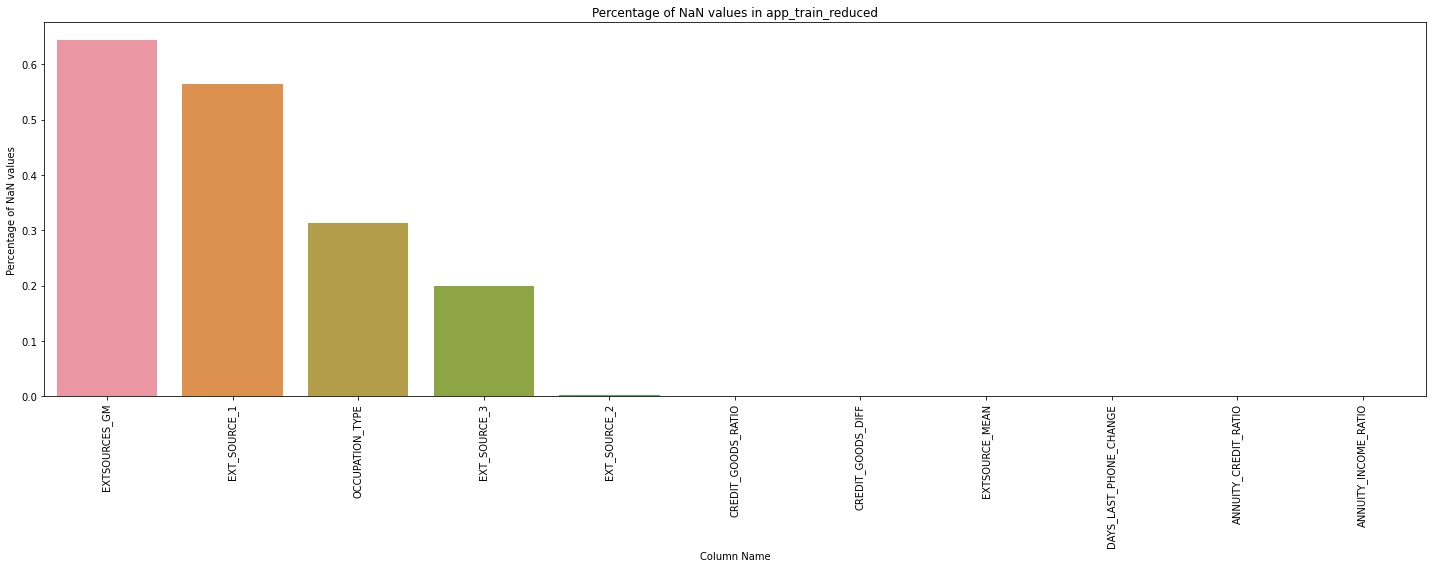

In [67]:
plot_missing(count_miss_train1, 'app_train_reduced')

In [68]:
# app_test_df
count_miss_test1 = count_missing_value(app_test_df, print_info=True)
count_miss_test1

There are 27 columns in total 
There are 8 columns have miss values


,miss_value,% miss_percentage
EXTSOURCES_GM,25160,0.5162
EXT_SOURCE_1,20532,0.4212
OCCUPATION_TYPE,15605,0.3201
EXT_SOURCE_3,8668,0.1778
ANNUITY_CREDIT_RATIO,24,0.0005
ANNUITY_INCOME_RATIO,24,0.0005
EXT_SOURCE_2,8,0.0002
EXTSOURCE_MEAN,7,0.0001


Number of columns having NaN values: 8 columns


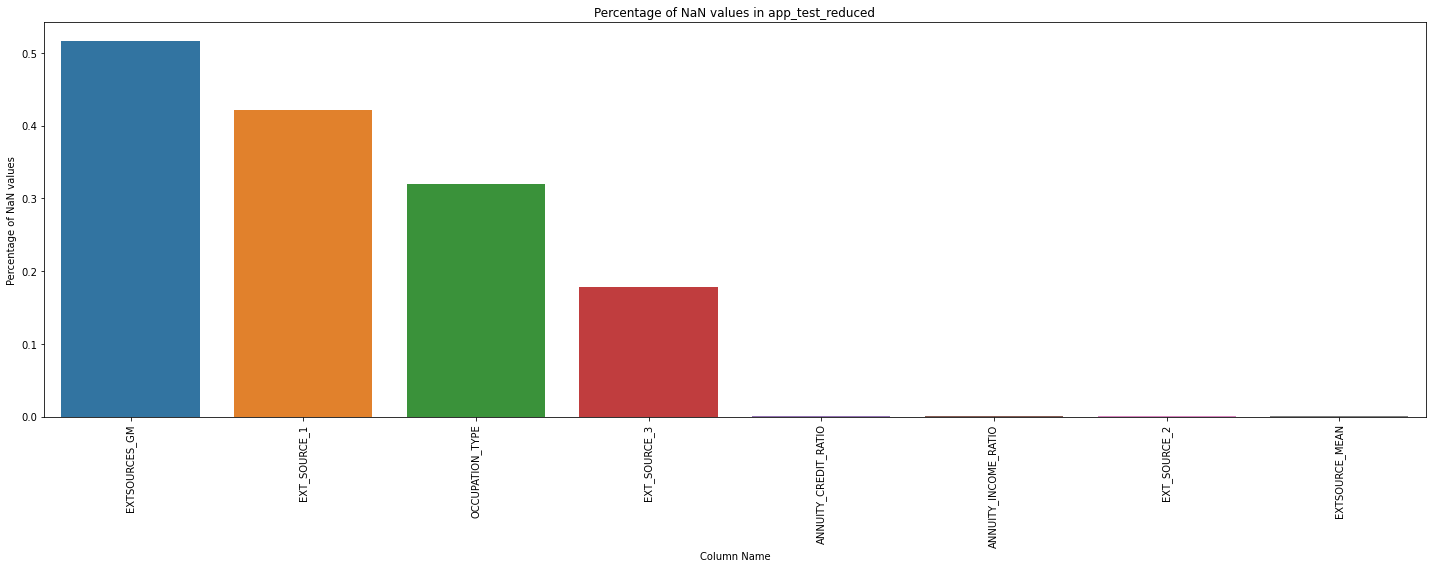

In [69]:
plot_missing(count_miss_test1, 'app_test_reduced')

For categorical values, we can use a string 'Missing' (as another category for augmentation) to fill NaN values.

For numerical values, we can use mean value to simply fill NaN values.

In [70]:
# app_train_df
# MISSING_COLS_train = ['EXT_SOURCE_1','OCCUPATION_TYPE','EXT_SOURCE_3','EXT_SOURCE_2','DAYS_LAST_PHONE_CHANGE',]
MISSING_COLS_train = count_miss_train1.index.to_list()

for each_col in MISSING_COLS_train:
    if each_col in CATE_FEATS:
        app_train_df[each_col] = app_train_df[each_col].fillna('Missing')
    elif each_col in NUM_FEATS:
        app_train_df[each_col] = app_train_df[each_col].replace(np.NaN, app_train_df[each_col].mean())
        
app_train_df.head()

,SK_ID_CURR,TARGET,ORGANIZATION_TYPE,OCCUPATION_TYPE,NAME_INCOME_TYPE,REGION_RATING_CLIENT_W_CITY,NAME_EDUCATION_TYPE,CODE_GENDER,REG_CITY_NOT_WORK_CITY,REG_CITY_NOT_LIVE_CITY,...,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,DAYS_EMPLOYED_RATIO,EXTSOURCE_MEAN,EXTSOURCES_GM,ANNUITY_CREDIT_RATIO,ANNUITY_INCOME_RATIO,INCOME_CREDIT_RATIO,CREDIT_GOODS_RATIO,CREDIT_GOODS_DIFF
0,100002,1,Business Entity Type 3,Laborers,Working,2,Secondary / secondary special,M,0,0,...,-1134.0,-2120,0.067329,0.161787,0.144914,0.060749,0.121978,0.498036,1.158397,55597.5
1,100003,0,School,Core staff,State servant,1,Higher education,F,0,0,...,-828.0,-291,0.070862,0.466757,0.483200,0.027598,0.132217,0.208736,1.145199,164002.5
2,100004,0,Government,Laborers,Working,2,Secondary / secondary special,M,0,0,...,-815.0,-2531,0.011814,0.642739,0.483200,0.050000,0.100000,0.500000,1.000000,0.0
3,100006,0,Business Entity Type 3,Laborers,Working,2,Secondary / secondary special,F,0,0,...,-617.0,-2437,0.159905,0.650442,0.483200,0.094941,0.219900,0.431748,1.052803,15682.5
4,100007,0,Religion,Core staff,Working,2,Secondary / secondary special,M,1,0,...,-1106.0,-3458,0.152418,0.322738,0.483200,0.042623,0.179963,0.236842,1.000000,0.0


In [71]:
# app_test_df
# MISSING_COLS_test = ['EXT_SOURCE_1','OCCUPATION_TYPE','EXT_SOURCE_3','EXT_SOURCE_2']
MISSING_COLS_test = count_miss_test1.index.to_list()

for each_col in MISSING_COLS_test:
    if each_col in CATE_FEATS:
        app_test_df[each_col] = app_test_df[each_col].fillna('Missing')
    elif each_col in NUM_FEATS:
        app_test_df[each_col] = app_test_df[each_col].replace(np.NaN, app_test_df[each_col].mean())
    
app_test_df.head()

,SK_ID_CURR,ORGANIZATION_TYPE,OCCUPATION_TYPE,NAME_INCOME_TYPE,REGION_RATING_CLIENT_W_CITY,NAME_EDUCATION_TYPE,CODE_GENDER,REG_CITY_NOT_WORK_CITY,REG_CITY_NOT_LIVE_CITY,FLAG_DOCUMENT_3,...,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,DAYS_EMPLOYED_RATIO,EXTSOURCE_MEAN,EXTSOURCES_GM,ANNUITY_CREDIT_RATIO,ANNUITY_INCOME_RATIO,INCOME_CREDIT_RATIO,CREDIT_GOODS_RATIO,CREDIT_GOODS_DIFF
0,100001,Kindergarten,Missing,Working,2,Higher education,F,0,0,1,...,-1740.0,-812,0.121044,0.567263,0.455975,0.036147,0.152300,0.237342,1.2640,118800.0
1,100005,Self-employed,Low-skill Laborers,Working,2,Secondary / secondary special,M,0,0,1,...,0.0,-1623,0.247398,0.429869,0.414750,0.077973,0.175455,0.444409,1.2376,42768.0
2,100013,Transport: type 3,Drivers,Working,2,Higher education,M,0,0,0,...,-856.0,-3503,0.222477,0.655389,0.481913,0.105202,0.344578,0.305308,1.0528,33264.0
3,100028,Business Entity Type 3,Sales staff,Working,2,Secondary / secondary special,F,0,0,1,...,-1805.0,-4208,0.133515,0.549372,0.547567,0.031123,0.155614,0.200000,1.0000,0.0
4,100038,Business Entity Type 3,Missing,Working,2,Secondary / secondary special,M,1,0,1,...,-821.0,-4262,0.168021,0.313916,0.481913,0.051266,0.178150,0.287770,1.0000,0.0


#### Feature instances encoding

In [72]:
app_train_df.select_dtypes('object').apply(pd.Series.nunique).sort_values(ascending=False)

ORGANIZATION_TYPE              58
OCCUPATION_TYPE                19
NAME_INCOME_TYPE                8
NAME_HOUSING_TYPE               6
NAME_FAMILY_STATUS              6
NAME_EDUCATION_TYPE             5
CODE_GENDER                     3
REGION_RATING_CLIENT_W_CITY     3
LIVE_CITY_NOT_WORK_CITY         2
FLAG_DOCUMENT_3                 2
REG_CITY_NOT_LIVE_CITY          2
REG_CITY_NOT_WORK_CITY          2
dtype: int64

In [73]:
print(app_train_df.shape)
print(app_test_df.shape)

(307511, 28)
(48744, 27)


In [74]:
BI_CLASSES = ['REG_CITY_NOT_WORK_CITY', 'REG_CITY_NOT_LIVE_CITY', 'FLAG_DOCUMENT_3', 'LIVE_CITY_NOT_WORK_CITY']
MULTI_CLASSES = ['ORGANIZATION_TYPE', 'OCCUPATION_TYPE', 'NAME_INCOME_TYPE', 'REGION_RATING_CLIENT_W_CITY', 'NAME_EDUCATION_TYPE', 'CODE_GENDER', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']

app_train_df = feature_class_encoding(app_train_df, BI_CLASSES, MULTI_CLASSES)
app_test_df = feature_class_encoding(app_test_df, BI_CLASSES, MULTI_CLASSES)

(307511, 128)
(48744, 125)


In [75]:
app_train_df.head()

,SK_ID_CURR,TARGET,REG_CITY_NOT_WORK_CITY,REG_CITY_NOT_LIVE_CITY,FLAG_DOCUMENT_3,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,DAYS_BIRTH,...,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents
0,100002,1,0,0,1,0,0.139376,0.262949,0.083037,-9461,...,0,1,0,0,0,1,0,0,0,0
1,100003,0,0,0,1,0,0.510853,0.622246,0.311267,-16765,...,0,0,0,0,0,1,0,0,0,0
2,100004,0,0,0,0,0,0.729567,0.555912,0.502130,-19046,...,0,1,0,0,0,1,0,0,0,0
3,100006,0,0,0,1,0,0.510853,0.650442,0.502130,-19005,...,0,0,0,0,0,1,0,0,0,0
4,100007,0,1,0,0,1,0.510853,0.322738,0.502130,-19932,...,0,1,0,0,0,1,0,0,0,0


In [76]:
app_test_df.head()

,SK_ID_CURR,REG_CITY_NOT_WORK_CITY,REG_CITY_NOT_LIVE_CITY,FLAG_DOCUMENT_3,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,DAYS_BIRTH,DAYS_LAST_PHONE_CHANGE,...,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents
0,100001,0,0,1,0,0.159520,0.789654,0.752614,-19241,-1740.0,...,1,0,0,0,0,1,0,0,0,0
1,100005,0,0,1,0,0.432962,0.291656,0.564990,-18064,0.0,...,1,0,0,0,0,1,0,0,0,0
2,100013,0,0,0,0,0.610991,0.699787,0.501180,-20038,-856.0,...,1,0,0,0,0,1,0,0,0,0
3,100028,0,0,1,0,0.612704,0.509677,0.525734,-13976,-1805.0,...,1,0,0,0,0,1,0,0,0,0
4,100038,1,0,1,1,0.500106,0.425687,0.202145,-13040,-821.0,...,1,0,0,0,0,1,0,0,0,0


In [77]:
print(app_train_df.shape)
print(app_test_df.shape)

(307511, 128)
(48744, 125)


After encoding, shape: (307511, 120)，(48744, 117).

<!-- 由于测试集和训练集在有些特征中的取值范围是不同的，所以编码后的维数存在差异，我们应该使用df.align对齐数据。 -->
Dimension of training dataset & testing dataset exists differences (since the exact classes in app_train_df & app_test_df for each features may slightly various)

In [78]:
app_train_features = app_train_df.drop('TARGET', axis=1)
app_train_target = app_train_df['TARGET']

# 只对app_train的features进行align，因为后续要保留app_train的TARGET
app_train_features, app_test_df = app_train_features.align(app_test_df,join='inner',axis=1)

app_train_df = pd.concat([app_train_features, app_train_target], axis=1)

print(app_train_df.shape)
print(app_test_df.shape)

(307511, 125)
(48744, 124)


In [79]:
app_train_df.head()

,SK_ID_CURR,REG_CITY_NOT_WORK_CITY,REG_CITY_NOT_LIVE_CITY,FLAG_DOCUMENT_3,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,DAYS_BIRTH,DAYS_LAST_PHONE_CHANGE,...,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,TARGET
0,100002,0,0,1,0,0.139376,0.262949,0.083037,-9461,-1134.0,...,0,1,0,0,1,0,0,0,0,1
1,100003,0,0,1,0,0.510853,0.622246,0.311267,-16765,-828.0,...,0,0,0,0,1,0,0,0,0,0
2,100004,0,0,0,0,0.729567,0.555912,0.502130,-19046,-815.0,...,0,1,0,0,1,0,0,0,0,0
3,100006,0,0,1,0,0.510853,0.650442,0.502130,-19005,-617.0,...,0,0,0,0,1,0,0,0,0,0
4,100007,1,0,0,1,0.510853,0.322738,0.502130,-19932,-1106.0,...,0,1,0,0,1,0,0,0,0,0


## Model Training (LightGBM)

Before the model is trained, we need to split the data into train and test in advance. This is going to be useful to find out whether our final model suffers overfitting. To do so, we are going to employ train_test_split() function taken from Sklearn module.

In [80]:
X = app_train_df.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = app_train_df['TARGET']

X_test = app_test_df.drop(['SK_ID_CURR'], axis=1)

#### Simple train_test_split

In [81]:
# X = app_train_df.drop(['SK_ID_CURR', 'TARGET'], axis=1).values
# y = app_train_df['TARGET'].values

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)
# # cross-validation can also be performed!!!

#### Nomalization

In [82]:
# Value normalization
scaler = StandardScaler()

pre_cols = X.columns
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=pre_cols)

pre_cols1 = X_test.columns
X_test = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test, columns=pre_cols1)

#### Model Training

In [83]:
# # Initializing LightGBM classifier

# # lgb_clf = lgb.LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=22)
# lgb_clf = lgb.LGBMClassifier(n_estimators=1000, objective = 'binary', 
#                                    class_weight = 'balanced', learning_rate = 0.05, 
#                                    reg_alpha = 0.1, reg_lambda = 0.1, 
#                                    subsample = 0.8, n_jobs = -1, random_state = 50)

# # Training the LightGBM model
# lgb_clf.fit(X_train_scaled, y_train, eval_metric='auc', 
#           eval_set=[(X_train_scaled, y_train),(X_test_scaled, y_test)])

In [84]:
processed_col = list()
for string in X.columns:
    a = ''.join(char for char in string if char.isalnum())
    processed_col.append(a)
    
X.columns = processed_col



processed_col1 = list()
for string1 in X_test.columns:
    a = ''.join(char for char in string1 if char.isalnum())
    processed_col1.append(a)
    
X_test.columns = processed_col1

In [161]:
bopt_lgbm = BayesianOptimization(lgbm_evaluation, {'num_leaves' : (25,50),
                                                   'max_depth' : (6,11),
                                                   'min_split_gain' : (0, 0.1),
                                                   'min_child_weight' : (5,80),
                                                   'min_child_samples' : (5,80),
                                                   'subsample' : (0.5,1),
                                                   'colsample_bytree' : (0.5,1),
                                                   'reg_alpha' : (0.001, 0.3),
                                                   'reg_lambda' : (0.001, 0.3)},
                                 random_state = 4976)

bayesian_optimization = bopt_lgbm.maximize(n_iter=6, init_points=4)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7668   |  0.9839   |  9.624    |  65.58    |  60.98    |  0.08223  |  39.55    |  0.1133   |  0.2049   |  0.6677   |
|  2        |  0.7675   |  0.5453   |  10.99    |  36.09    |  42.7     |  0.02383  |  43.12    |  0.1206   |  0.1951   |  0.8343   |
|  3        |  0.7669   |  0.7313   |  9.478    |  47.08    |  53.08    |  0.0249   |  36.94    |  0.2417   |  0.1072   |  0.5916   |
|  4        |  0.7669   |  0.5671   |  7.674    |  26.69    |  8.717    |  0.004937 |  31.48    |  0.118    |  0.09472  |  0.9706   |
|  5        |  0.767    |  0.843    |  10.6     |  46.36    |  16.37    |  0.0809   |  31.43    |  0.03722  |  0.2425   |  0.8722   |
|  6        |  0.7674   |  0.6623   |  8.873    |  31.68    | 

In [162]:
#extracting the best parameters
target_values = []
for result in bopt_lgbm.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']
print("Best Hyperparameters obtained are:\n")
print(best_params)

Best Hyperparameters obtained are:

{'colsample_bytree': 0.5453481803843285, 'max_depth': 10.994238196555454, 'min_child_samples': 36.094466384848104, 'min_child_weight': 42.69837589745545, 'min_split_gain': 0.023832030441816324, 'num_leaves': 43.12210378807271, 'reg_alpha': 0.12058913831355167, 'reg_lambda': 0.1951050278798116, 'subsample': 0.8343200716558421}


#### Training on Optimized Parameters

In [85]:
params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
        'learning_rate' : 0.005,
        'n_estimators' : 10000,
        'n_jobs' : -1,
        'num_leaves' : 43,
        #'max_depth' : 9,
        'max_depth' :11,
        'min_split_gain' : 0.023832030441816324,
        'min_child_weight' :  42.69837589745545,
        'min_child_samples' : 36,
        'subsample': 0.8343200716558421,
        'subsample_freq' : 1,
        'colsample_bytree' : 0.5453481803843285,
        'reg_alpha' : 0.12058913831355167,
        'reg_lambda' : 0.1951050278798116,
        'verbosity' : -1,
        'seed' : 266
    }
lgbm_boosting = Boosting(X, y, X_test, params, random_state = 98, save_model_to_pickle = True)
lgbm_boosting.train(booster = 'lightgbm')

Fitting the lightgbm on Training Data with 5 fold cross validation, and using Out-Of-Folds Predictions for Cross-Validation

	Fold Number 1

Training until validation scores don't improve for 200 rounds.
[400]	training's auc: 0.761354	training's binary_logloss: 0.247609	valid_1's auc: 0.75436	valid_1's binary_logloss: 0.249467
[800]	training's auc: 0.77383	training's binary_logloss: 0.241792	valid_1's auc: 0.761221	valid_1's binary_logloss: 0.245578
[1200]	training's auc: 0.783098	training's binary_logloss: 0.238532	valid_1's auc: 0.765132	valid_1's binary_logloss: 0.244172
[1600]	training's auc: 0.790004	training's binary_logloss: 0.236222	valid_1's auc: 0.766768	valid_1's binary_logloss: 0.243614
[2000]	training's auc: 0.795969	training's binary_logloss: 0.234254	valid_1's auc: 0.767531	valid_1's binary_logloss: 0.243355
[2400]	training's auc: 0.801431	training's binary_logloss: 0.23244	valid_1's auc: 0.767976	valid_1's binary_logloss: 0.243192
[2800]	training's auc: 0.806499	trainin

Train Results:

The best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = 0.020892953251537207

	ROC-AUC Score = 0.8215516552589436
	Precision Score = 0.19505400619284818
	Recall Score = 0.758710976837865
CV Results:
	ROC-AUC Score = 0.7670148810362889
	Precision Score = 0.0942692861687635
	Recall Score = 0.972809667673716


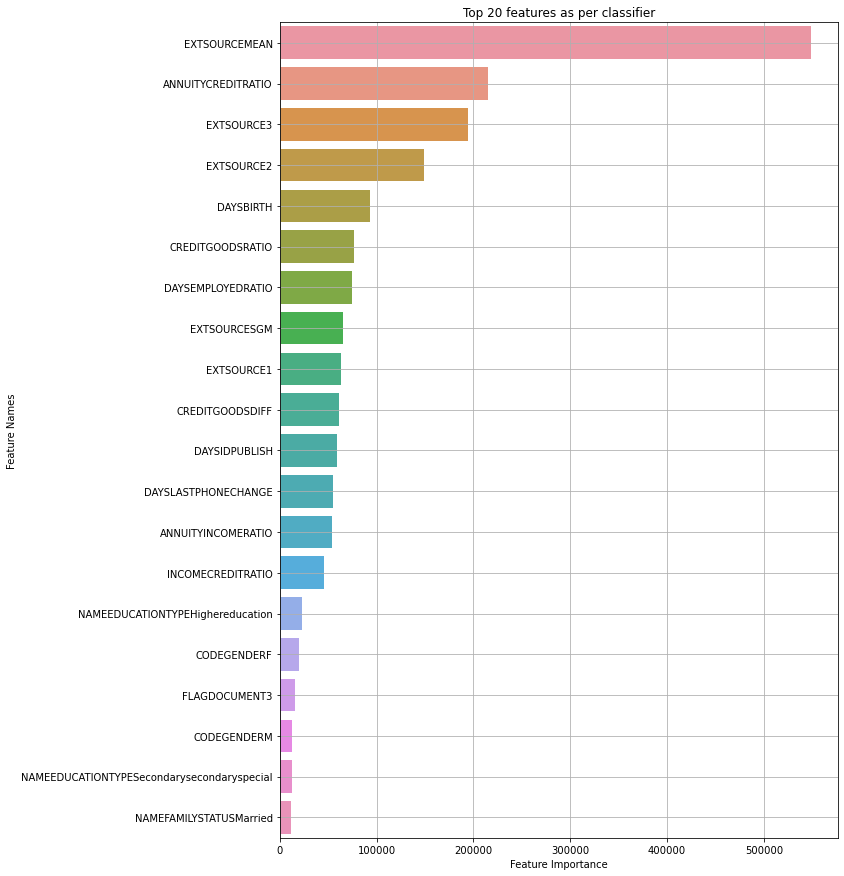

In [86]:
#displaying the results and metrics
lgbm_boosting.results()
#displaying top 20 important features
lgbm_boosting.feat_importances_show(20)

In [87]:
features_with_zero_importances  = lgbm_boosting.feature_importance[lgbm_boosting.feature_importance.gain == 0]

print(f"There are {len(features_with_zero_importances)} features with Zero Gain in LGBMClassifier. They are:\n")
print(features_with_zero_importances.features.values)

There are 30 features with Zero Gain in LGBMClassifier. They are:

['ORGANIZATIONTYPETradetype5' 'ORGANIZATIONTYPETradetype6'
 'OCCUPATIONTYPERealtyagents' 'ORGANIZATIONTYPETransporttype1'
 'ORGANIZATIONTYPEIndustrytype5' 'OCCUPATIONTYPEITstaff'
 'OCCUPATIONTYPEHRstaff' 'ORGANIZATIONTYPEIndustrytype8'
 'NAMEEDUCATIONTYPEAcademicdegree' 'NAMEINCOMETYPEUnemployed'
 'NAMEINCOMETYPEStudent' 'NAMEINCOMETYPEBusinessman'
 'ORGANIZATIONTYPETradetype4' 'ORGANIZATIONTYPETradetype1'
 'ORGANIZATIONTYPEAdvertising' 'ORGANIZATIONTYPELegalServices'
 'ORGANIZATIONTYPETelecom' 'ORGANIZATIONTYPECleaning'
 'ORGANIZATIONTYPECulture' 'ORGANIZATIONTYPEElectricity'
 'ORGANIZATIONTYPEEmergency' 'ORGANIZATIONTYPEReligion'
 'ORGANIZATIONTYPERealtor' 'ORGANIZATIONTYPEIndustrytype10'
 'ORGANIZATIONTYPEInsurance' 'ORGANIZATIONTYPEIndustrytype12'
 'ORGANIZATIONTYPEMobile' 'ORGANIZATIONTYPEIndustrytype13'
 'ORGANIZATIONTYPEIndustrytype2' 'ORGANIZATIONTYPEIndustrytype6']


## Submit Result

In [88]:
#submitting the result
# pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : lgbm_boosting.test_preds_proba_mean}).to_csv('LGBM_3folds.csv',index = False)


# Write final results to submission.csv
app_pred_df = pd.DataFrame(lgbm_boosting.test_preds_proba_mean, columns=['TARGET'])
app_pred_ids = pd.DataFrame(app_test_df['SK_ID_CURR'], columns=['SK_ID_CURR'])
final_df = pd.concat([app_pred_ids, app_pred_df], axis=1)
final_df.head()

,SK_ID_CURR,TARGET
0,100001,0.021422
1,100005,0.071864
2,100013,0.034266
3,100028,0.025375
4,100038,0.101609


In [90]:
submission_dir = './submission/lgbm5folds.csv'
final_df.to_csv(submission_dir, index=False)